<a href="https://colab.research.google.com/github/annaluizacaraciolo/DeepLearning2023/blob/main/Projeto_DangerousFarmInsects.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [3]:
from sklearn.model_selection import train_test_split
from google.colab import files

# Importando dataset

In [ ]:
! pip install -q kaggle
files.upload()

In [5]:
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle datasets download tarundalal/dangerous-insects-dataset

 99% 441M/447M [00:06<00:00, 72.3MB/s]
100% 447M/447M [00:06<00:00, 74.4MB/s]


In [7]:
!unzip -q /content/dangerous-insects-dataset

# Armazenando o dataset

In [8]:
import pathlib
data = tf.keras.utils.image_dataset_from_directory("farm_insects", labels="inferred")
data_dir = pathlib.Path("farm_insects")

Found 1591 files belonging to 15 classes.


In [9]:
batch_size = 32
img_height = 224
img_width = 224

In [10]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1591 files belonging to 15 classes.
Using 1273 files for training.


In [11]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 1591 files belonging to 15 classes.
Using 318 files for validation.


A opção abaixo otimiza o treinamento ao deixar em memória os dados que forem utilizados na primeira epoch.
https://www.tensorflow.org/tutorials/images/classification?hl=pt-br#configure_the_dataset_for_performance

In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

# Análise exploratória de dados

## Conhecendo o conjunto de dados

In [13]:
num_classes = len(data.class_names)
print("Number of classes:", num_classes)

Number of classes: 15


In [14]:
for species in data.class_names:
  class_name = species
  image_count = len(os.listdir('farm_insects/' + class_name))
  print(f"Class '{class_name}' has {image_count} images.")

Class 'Africanized Honey Bees (Killer Bees)' has 97 images.
Class 'Aphids' has 88 images.
Class 'Armyworms' has 96 images.
Class 'Brown Marmorated Stink Bugs' has 114 images.
Class 'Cabbage Loopers' has 104 images.
Class 'Citrus Canker' has 104 images.
Class 'Colorado Potato Beetles' has 112 images.
Class 'Corn Borers' has 115 images.
Class 'Corn Earworms' has 110 images.
Class 'Fall Armyworms' has 113 images.
Class 'Fruit Flies' has 101 images.
Class 'Spider Mites' has 119 images.
Class 'Thrips' has 109 images.
Class 'Tomato Hornworms' has 109 images.
Class 'Western Corn Rootworms' has 100 images.


A partir da análise de quantiade de imagens presentes nas amostras de cada classe, percebemos que o conjunto de dados trabalhado é bem distribuído.

## Visualizando o conjunto de dados

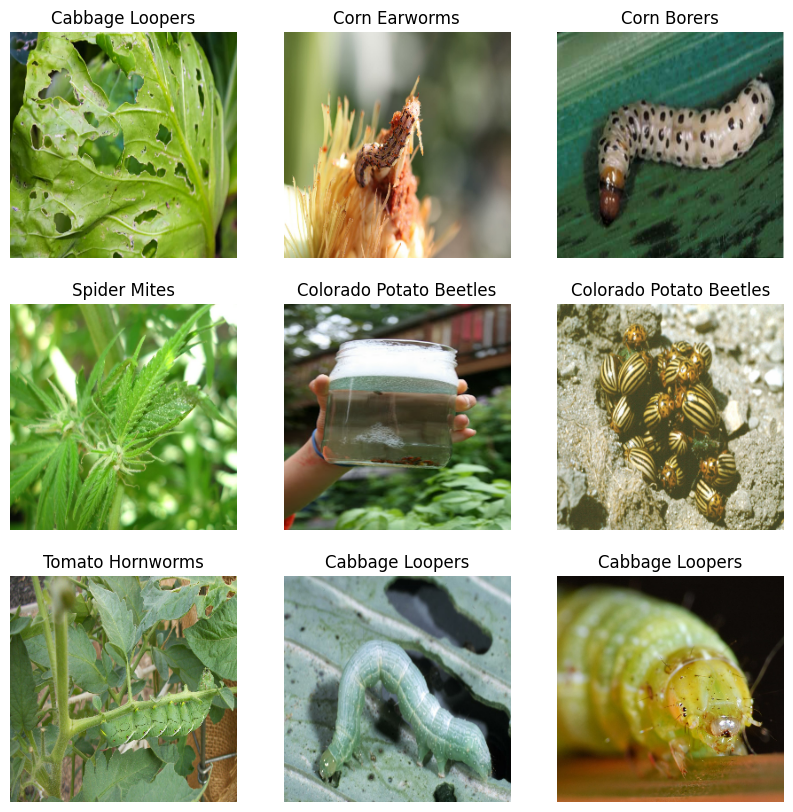

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in data.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(data.class_names[labels[i]])
        plt.axis("off")
plt.show()


## Dimensão das imagens

In [16]:
import tensorflow as tf
import pathlib

data_dir = pathlib.Path("farm_insects")
data = tf.keras.utils.image_dataset_from_directory(data_dir, labels="inferred", image_size=(224, 224))

# Get image dimensions
image_shapes = set()
for images, _ in data:
    for image in images:
        image_shapes.add(image.shape)

print("Different image shapes found in the dataset:")
print(image_shapes)

# Check if images have consistent dimensions
if len(image_shapes) == 1:
    print("All images have consistent dimensions.")
    image_height, image_width, num_channels = image_shapes.pop()
else:
    print("Images have varying dimensions.")
    # Decide on a common size for resizing, e.g., (height, width)
    common_image_size = (224, 224)  # You can change this to your preferred size
    image_height, image_width, num_channels = common_image_size


Found 1591 files belonging to 15 classes.
Different image shapes found in the dataset:
{TensorShape([224, 224, 3])}
All images have consistent dimensions.


## Data augmentaion

Vamos testar a visualizar a técnica de data augmentation para uma imagem do nosso conjunto de dados. O objetivo da aplicação dessa técnica será para aumentar a quantidade de amostras que temos

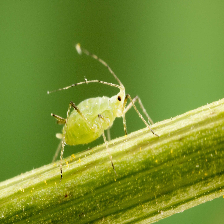

In [17]:
from tensorflow.keras.preprocessing import image

img_path = 'farm_insects/Aphids/Image_1.jpeg'
img = image.load_img(img_path, target_size=(224, 224, 3))
display(img)


In [18]:
rescale = tf.keras.Sequential([
  layers.Rescaling(1./255)
])

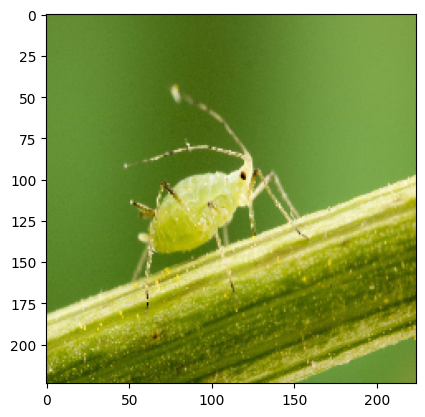

In [19]:
result = rescale(img)
plt.imshow(result)

In [20]:
print("Min and max pixel values:", result.numpy().min(), result.numpy().max())

Min and max pixel values: 0.0 1.0


In [21]:
# Add the image to a batch.
image = tf.expand_dims(result, 0)

In [22]:
data_augmentation = tf.keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
])

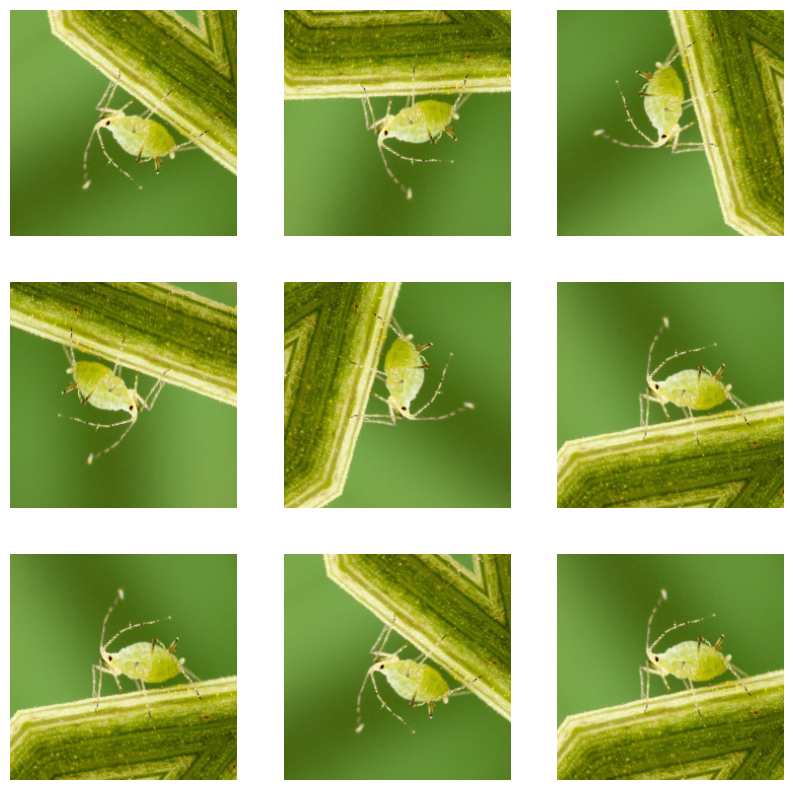

In [23]:
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(augmented_image[0])
  plt.axis("off")

Aplicando data augmentation em todo o dataset

In [24]:
train_ds = train_ds.map(
  lambda x, y: (rescale(x, training=True), y))

In [25]:
train_ds = train_ds.map(
  lambda x, y: (data_augmentation(x, training=True), y))

# Treinamento
- Fazer o treinamento de uma rede VGG pré treinada no ImageNet (transfer learning)
- Fazer o treinamento de uma rede VGG com o dataset Dangerous Farm Insects
- Fazer o treinamento de uma MobileNet (pois é econômica de recursos) ou densenet

## VGG - Transfer learning

Aplicando o passo a passo da documentação do Keras [Transfer learning & fine-tuning](https://keras.io/guides/transfer_learning/#the-typical-transferlearning-workflow)

In [26]:
base_model = keras.applications.VGG16(
    weights="imagenet",
    input_shape=(224, 224, 3),
    include_top=False)  # Do not include the ImageNet classifier at the top.

58889256/58889256 [==============================] - 0s 0us/step


In [27]:
base_model.trainable = False

In [28]:
inputs = keras.Input(shape=(224, 224, 3))
# We make sure that the base_model is running in inference mode here,
# by passing `training=False`. This is important for fine-tuning, as you will
# learn in a few paragraphs.
x = base_model(inputs, training=False)
# Convert features of shape `base_model.output_shape[1:]` to vectors
x = keras.layers.GlobalAveragePooling2D()(x)
# A Dense classifier with 15 neurons
outputs = keras.layers.Dense(15, activation="softmax")(x)
model = keras.Model(inputs, outputs)

In [29]:
model.compile(optimizer=keras.optimizers.Adam(),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_ds, epochs=10)

Epoch 1/10
40/40 [==============================] - 40s 377ms/step - loss: 2.7724 - sparse_categorical_accuracy: 0.0935
Epoch 2/10
40/40 [==============================] - 12s 289ms/step - loss: 2.6086 - sparse_categorical_accuracy: 0.1650
Epoch 3/10
40/40 [==============================] - 12s 290ms/step - loss: 2.5148 - sparse_categorical_accuracy: 0.2482
Epoch 4/10
40/40 [==============================] - 12s 291ms/step - loss: 2.4370 - sparse_categorical_accuracy: 0.2773
Epoch 5/10
40/40 [==============================] - 12s 295ms/step - loss: 2.3745 - sparse_categorical_accuracy: 0.3103
Epoch 6/10
40/40 [==============================] - 12s 297ms/step - loss: 2.3115 - sparse_categorical_accuracy: 0.3409
Epoch 7/10
40/40 [==============================] - 12s 291ms/step - loss: 2.2552 - sparse_categorical_accuracy: 0.3716
Epoch 8/10
40/40 [==============================] - 12s 294ms/step - loss: 2.1946 - sparse_categorical_accuracy: 0.3810
Epoch 9/10
40/40 [======================

### Fine tuning

In [30]:
base_model.trainable = True

In [31]:
model.compile(optimizer=keras.optimizers.Adam(1e-5),
              loss=keras.losses.SparseCategoricalCrossentropy(),
              metrics=[keras.metrics.SparseCategoricalAccuracy()])
model.fit(train_ds, epochs=10)

Epoch 1/10
40/40 [==============================] - 36s 568ms/step - loss: 1.8126 - sparse_categorical_accuracy: 0.4548
Epoch 2/10
40/40 [==============================] - 18s 435ms/step - loss: 1.4823 - sparse_categorical_accuracy: 0.5389
Epoch 3/10
40/40 [==============================] - 19s 458ms/step - loss: 1.3183 - sparse_categorical_accuracy: 0.5899
Epoch 4/10
40/40 [==============================] - 19s 466ms/step - loss: 1.2064 - sparse_categorical_accuracy: 0.5994
Epoch 5/10
40/40 [==============================] - 18s 440ms/step - loss: 1.1138 - sparse_categorical_accuracy: 0.6394
Epoch 6/10
40/40 [==============================] - 18s 449ms/step - loss: 1.0537 - sparse_categorical_accuracy: 0.6575
Epoch 7/10
40/40 [==============================] - 18s 440ms/step - loss: 0.9422 - sparse_categorical_accuracy: 0.7046
Epoch 8/10
40/40 [==============================] - 19s 477ms/step - loss: 0.8762 - sparse_categorical_accuracy: 0.7188
Epoch 9/10
40/40 [======================